In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [121]:
pd.set_option('display.max_rows',100)

In [122]:
def dutycyclemode(rawdata,percent_batt):
    batt=percent_batt*96
    Consumption_afterPV=[]
    Charge=[]
    for i in rawdata.index:
        if rawdata.loc[i,'Generation']>=rawdata.loc[i,'Consumption']:
            Charge.append(rawdata.loc[i,'Generation']-rawdata.loc[i,'Consumption'])
            Consumption_afterPV.append(0)
        else:
            Charge.append(0)
            Consumption_afterPV.append(rawdata.loc[i,'Consumption']-rawdata.loc[i,'Generation'])    

    rawdata['Charge']=Charge
    rawdata['Consumption_afterPV']=Consumption_afterPV

    totalcharge=rawdata['Charge'].sum()/4

    datanotstart=rawdata[rawdata.Generation==0]
    dataonlystart=rawdata[rawdata.Generation!=0]
    start_time=dataonlystart.index[0]
    consumption_night=rawdata.loc[:start_time,'Consumption'].sum()/4

    if totalcharge+batt>9600:
        discharge_only_at_night=1
    else:
        discharge_only_at_night=0

    if batt-consumption_night>0.6*9600:
        batt_start=batt-consumption_night
    else:
        batt_start=0.6*9600


    contactor=[]

    for i in rawdata[rawdata.index[0]:start_time].drop(start_time).index:
        if discharge_only_at_night==1:
            contactor.append(1)
        else:
            contactor.append(0)

    for i in rawdata[start_time:].index:
        if rawdata.loc[i,'Charge'] > 0:
            contactor.append(1)
        elif batt_start+totalcharge <= 9600:
            contactor.append(0)
        else:
            contactor.append(1)

    rawdata['Contactor']=contactor

    remain=percent_batt/100*9600*4*0.4

    rawdata['Discharge']=rawdata['Contactor']*0
    for i in rawdata.index:
        if rawdata.loc[i,'Contactor']==1 and rawdata.loc[i,'Charge']==0:
            if remain >= rawdata.loc[i,'Consumption_afterPV']:
                rawdata.loc[i,'Discharge']= rawdata.loc[i,'Consumption_afterPV']
                remain=remain- rawdata.loc[i,'Consumption_afterPV']
            else:
                rawdata.loc[i,'Discharge']=remain
                remain=0
    return rawdata

In [123]:
def clean1(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    return rawdata

## Use only month 11

In [124]:
pathlist=[]
for i in range(1,31):
    pathlist.append('Energy_Balance_2018_11_'+str(i).zfill(2))
pathlist

['Energy_Balance_2018_11_01',
 'Energy_Balance_2018_11_02',
 'Energy_Balance_2018_11_03',
 'Energy_Balance_2018_11_04',
 'Energy_Balance_2018_11_05',
 'Energy_Balance_2018_11_06',
 'Energy_Balance_2018_11_07',
 'Energy_Balance_2018_11_08',
 'Energy_Balance_2018_11_09',
 'Energy_Balance_2018_11_10',
 'Energy_Balance_2018_11_11',
 'Energy_Balance_2018_11_12',
 'Energy_Balance_2018_11_13',
 'Energy_Balance_2018_11_14',
 'Energy_Balance_2018_11_15',
 'Energy_Balance_2018_11_16',
 'Energy_Balance_2018_11_17',
 'Energy_Balance_2018_11_18',
 'Energy_Balance_2018_11_19',
 'Energy_Balance_2018_11_20',
 'Energy_Balance_2018_11_21',
 'Energy_Balance_2018_11_22',
 'Energy_Balance_2018_11_23',
 'Energy_Balance_2018_11_24',
 'Energy_Balance_2018_11_25',
 'Energy_Balance_2018_11_26',
 'Energy_Balance_2018_11_27',
 'Energy_Balance_2018_11_28',
 'Energy_Balance_2018_11_29',
 'Energy_Balance_2018_11_30']

In [125]:
rawdata=[]
for i in pathlist:
    df=clean1(i)
    rawdata.append(df)
rawdata

[                     Generation  Consumption
 Time                                        
 2018-11-01 00:15:00           0         1615
 2018-11-01 00:30:00           0         1934
 2018-11-01 00:45:00           0         1655
 2018-11-01 01:00:00           0         1512
 2018-11-01 01:15:00           0         1871
 2018-11-01 01:30:00           0         1563
 2018-11-01 01:45:00           0         1522
 2018-11-01 02:00:00           0         1293
 2018-11-01 02:15:00           0         1685
 2018-11-01 02:30:00           0         1480
 2018-11-01 02:45:00           0         1494
 2018-11-01 03:00:00           0         1402
 2018-11-01 03:15:00           0         1368
 2018-11-01 03:30:00           0         1388
 2018-11-01 03:45:00           0          914
 2018-11-01 04:00:00           0          811
 2018-11-01 04:15:00           0         1302
 2018-11-01 04:30:00           0         1225
 2018-11-01 04:45:00           0         1050
 2018-11-01 05:00:00           0  

In [126]:
rawdata[0]

,Generation,Consumption
Time,,
2018-11-01 00:15:00,0,1615
2018-11-01 00:30:00,0,1934
2018-11-01 00:45:00,0,1655
2018-11-01 01:00:00,0,1512
2018-11-01 01:15:00,0,1871
2018-11-01 01:30:00,0,1563
2018-11-01 01:45:00,0,1522
2018-11-01 02:00:00,0,1293
2018-11-01 02:15:00,0,1685


In [127]:
batt_start=80
for i in range(len(rawdata)):
    rawdata[i]=dutycyclemode(rawdata[i],batt_start)
    rawdata[i]['Consumption_afterDischarge']=rawdata[i]['Consumption_afterPV']-rawdata[i]['Discharge']
    batt_start=batt_start+(rawdata[i].Charge.sum()-rawdata[i].Discharge.sum())/4/96
    print(batt_start)

99.32291666666667
109.4140625
108.859375
99.04739583333334
100.9440625
100.22529166666666
92.99975833333333
85.83631333333332
86.85714666666665
68.71585049999999
94.04918383333332
93.47638529999999
84.05718534666666
84.78066537466665
87.37100339146666
77.04760203488
94.25853953488
86.21658205426134
67.4721367325568
73.57963620620075
71.19205255705378
75.02252320089893
75.03955558720602
77.87008751899029
80.74549001139417
82.96552317350317
74.47723057076857
94.5761889041019
86.39935917579447
69.38909467214334


In [135]:
(rawdata[1].Charge.sum()-rawdata[1].Discharge.sum())/4/96

10.091145833333334

## Test Graph in 1 day

Text(0, 0.5, 'Watt(W)')

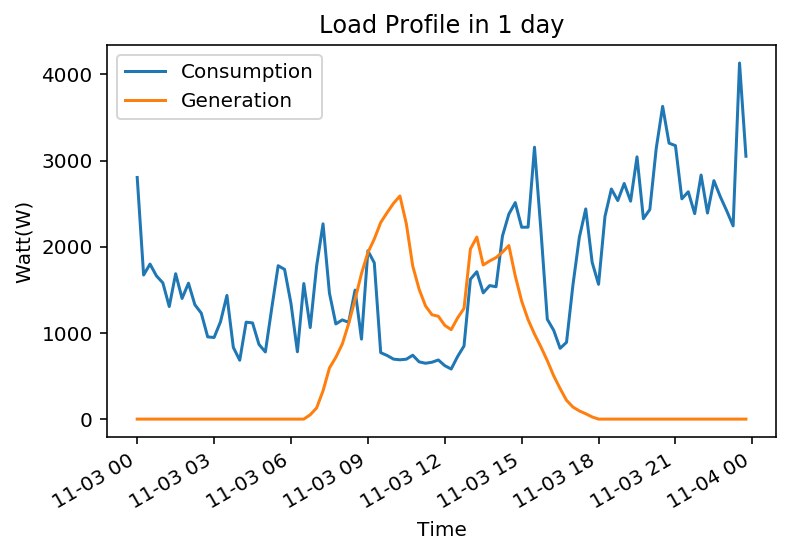

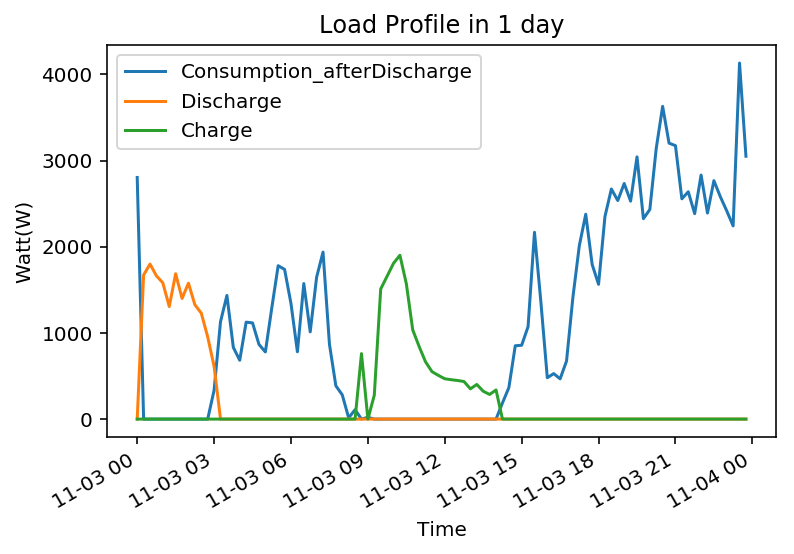

In [129]:
test_day=2
rawdata[test_day][['Consumption','Generation']].plot(kind='line',title='Load Profile in 1 day').set_ylabel('Watt(W)')
rawdata[test_day][['Consumption_afterDischarge','Discharge','Charge']].plot(kind='line',title='Load Profile in 1 day').set_ylabel('Watt(W)')

## Test no. of dutycycle

In [130]:
state=''
dutycycle=0
for i in range(len(rawdata)):
    for j in range(96):
        if rawdata[i].iloc[j,2] != 0:
            if state=='D':
                dutycycle+=1
                state='C'
            else:
                state='C'
        elif rawdata[i].iloc[j,5] != 0:
            if state=='C':
                dutycycle+=1
                state='D'
            else:
                state='D'
dutycycle

51

In [131]:
def clean2(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  'and i!= 'Battery charging / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    rawdata.rename(columns={'Battery discharging / Mean values [W] ':'Discharge'},inplace=True)
    rawdata.rename(columns={'Battery charging / Mean values [W]  ':'Charge'},inplace=True)    
    return rawdata

In [132]:
Realdata=[]
for i in pathlist:
    Realdata.append(clean2(i))
Realdata

[                     Discharge  Charge  Generation  Consumption
 Time                                                           
 2018-11-01 00:15:00          0       0           0         1615
 2018-11-01 00:30:00          0       0           0         1934
 2018-11-01 00:45:00          0       0           0         1655
 2018-11-01 01:00:00          0       0           0         1512
 2018-11-01 01:15:00          0       0           0         1871
 2018-11-01 01:30:00          0       0           0         1563
 2018-11-01 01:45:00          0       0           0         1522
 2018-11-01 02:00:00          0       0           0         1293
 2018-11-01 02:15:00          0       0           0         1685
 2018-11-01 02:30:00          0       0           0         1480
 2018-11-01 02:45:00          0       0           0         1494
 2018-11-01 03:00:00          0       0           0         1402
 2018-11-01 03:15:00          0       0           0         1368
 2018-11-01 03:30:00     

In [133]:
Realdata[0]

,Discharge,Charge,Generation,Consumption
Time,,,,
2018-11-01 00:15:00,0,0,0,1615
2018-11-01 00:30:00,0,0,0,1934
2018-11-01 00:45:00,0,0,0,1655
2018-11-01 01:00:00,0,0,0,1512
2018-11-01 01:15:00,0,0,0,1871
2018-11-01 01:30:00,0,0,0,1563
2018-11-01 01:45:00,0,0,0,1522
2018-11-01 02:00:00,0,0,0,1293
2018-11-01 02:15:00,0,0,0,1685


In [134]:
state=''
dutycycle=0
for i in range(len(Realdata)):
    for j in range(96):
        if Realdata[i].iloc[j,1] != 0:
            if state=='D':
                dutycycle+=1
                state='C'
            else:
                state='C'
        elif Realdata[i].iloc[j,0] != 0:
            if state=='C':
                dutycycle+=1
                state='D'
            else:
                state='D'
dutycycle

428